# Get Layer-wise Bert Embedding

In [1]:
import os
import pickle
import logging
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer

# Set up logging
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)

# File paths and model configuration
path = './output/user_texts.txt'
out_path = './'
model_name = 'sentence-transformers/all-MiniLM-L6-v2'  # Full Hugging Face model path

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the SentenceTransformer model and move it to the device
sentence_model = SentenceTransformer(model_name)
sentence_model.to(device)

# Access the transformer model and the pooling layer
transformer_model = sentence_model[0].auto_model  # The transformer model
pooling_layer = sentence_model[1]  # The pooling layer

# Ensure the transformer model outputs hidden states
transformer_model.config.output_hidden_states = True

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

if __name__ == '__main__':
    # Read the input sentences and remove empty lines
    with open(path, 'r', encoding='utf-8') as f:
        sentences = [line.strip() for line in f if line.strip()]

    print(f"Total sentences to process: {len(sentences)}")

    # Tokenize the sentences and move inputs to the correct device
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the hidden states from the transformer model
    with torch.no_grad():
        outputs = transformer_model(**inputs)
    hidden_states = outputs.hidden_states  # Tuple of (num_layers+1 x batch_size x seq_len x hidden_dim)

    # Create the save directory
    save_path = os.path.join(out_path, 'embeddings/')
    os.makedirs(save_path, exist_ok=True)

    # Process each layer's embeddings using the pooling layer
    for layer_index, layer_embeddings in enumerate(hidden_states):
        print(f"Processing layer {layer_index}/{len(hidden_states)-1}")

        # Prepare inputs for pooling
        pooling_input = {
            'token_embeddings': layer_embeddings,      # Shape: [batch_size, seq_len, hidden_dim]
            'attention_mask': inputs['attention_mask']  # Shape: [batch_size, seq_len]
        }

        # Apply the pooling layer to get sentence embeddings
        with torch.no_grad():
            pooling_output = pooling_layer(pooling_input)

        embeddings = pooling_output['sentence_embedding']  # Shape: [batch_size, hidden_dim]

        # Apply L2 normalization to match SentenceTransformer's default behavior
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

        # Convert embeddings to numpy array
        embeddings_np = embeddings.detach().cpu().numpy()  # Shape: (batch_size, hidden_dim)

        # Save the layer's sentence embeddings and sentences together
        file_path = os.path.join(save_path, f"layer_{layer_index}_sentence_embeddings.npz")
        np.savez(file_path, embeddings=embeddings_np, sentences=sentences)
        logging.info(f'{file_path} saved.')

    print("Sentence embeddings saved layer by layer.")


/home/pa21701/RAG/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-08 14:46:13 - Use pytorch device_name: cuda
2025-06-08 14:46:13 - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


Using device: cuda
Total sentences to process: 2458


2025-06-08 14:46:17 - ./embeddings/layer_0_sentence_embeddings.npz saved.
2025-06-08 14:46:17 - ./embeddings/layer_1_sentence_embeddings.npz saved.
2025-06-08 14:46:17 - ./embeddings/layer_2_sentence_embeddings.npz saved.
2025-06-08 14:46:17 - ./embeddings/layer_3_sentence_embeddings.npz saved.
2025-06-08 14:46:17 - ./embeddings/layer_4_sentence_embeddings.npz saved.
2025-06-08 14:46:17 - ./embeddings/layer_5_sentence_embeddings.npz saved.


Processing layer 0/6
Processing layer 1/6
Processing layer 2/6
Processing layer 3/6
Processing layer 4/6
Processing layer 5/6
Processing layer 6/6


2025-06-08 14:46:17 - ./embeddings/layer_6_sentence_embeddings.npz saved.


Sentence embeddings saved layer by layer.


# Get Attribute Boolean Matrix

In [2]:
import pandas as pd
import numpy as np
import ast

# Load the CSV file
file_path = './output/dialogue_data.csv'
data = pd.read_csv(file_path)

# Function to add commas between numbers in string representations of lists
def fix_format(matrix_str):
    return '[' + ','.join(matrix_str.strip('[]').split()) + ']'

boolean_embedding = np.array([ast.literal_eval(fix_format(matrix)) for matrix in data['binary_slot_matrix']])
# Display shapes to verify successful extraction

print("Boolean Embedding Shape:", boolean_embedding.shape)

Boolean Embedding Shape: (2458, 47)


# Get layer n embedding

In [3]:
import numpy as np

layer_index = 6  # Specify the layer you want to load
embedding_file = f'./embeddings/layer_{layer_index}_sentence_embeddings.npz'
sentence_data = np.load(embedding_file, allow_pickle=True)

sentence_embeddings = sentence_data['embeddings']  # Shape: (batch_size, hidden_dim)
sentences = sentence_data['sentences']    # List of sentences

print(f"Number of sentences: {len(sentences)}")
print(f"Number of embeddings: {sentence_embeddings.shape[0]}")


Number of sentences: 2458
Number of embeddings: 2458


In [4]:
sentence_embeddings.shape

(2458, 384)

# CCA: Pair all sentences with their embeddings

/home/pa21701/RAG/env/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/pa21701/RAG/env/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/pa21701/RAG/env/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/pa21701/RAG/env/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/pa21701/RAG/env/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: Converge

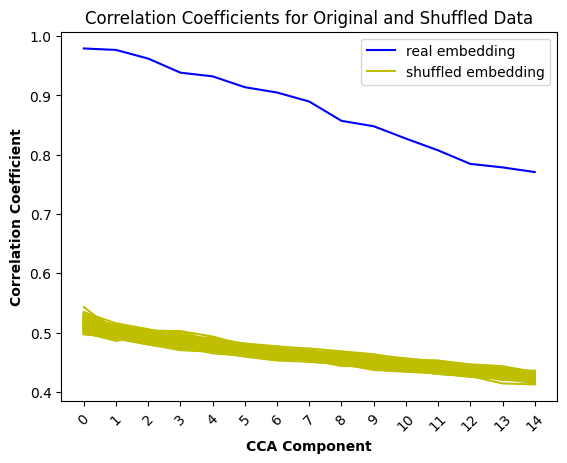

In [5]:
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

    
def plot_cca(X, Y):
    # num of components
#     n_comps = min(X.shape[1], Y.shape[1])
    n_comps = 15
    cca = CCA(n_components=n_comps)
    cca.fit(X, Y)
    X_c1, Y_c1 = cca.transform(X, Y)
    corrs1 = [np.corrcoef(X_c1[:, i], Y_c1[:, i])[0, 1] for i in range(n_comps)] 
    plt.plot(corrs1,'-b',label='real embedding')
    i=0
    while i < 100:
        Y_shuffled = shuffle(Y)
        cca1 = CCA(n_components=n_comps)
        cca1.fit(X, Y_shuffled)
        X_c2, Y_c2 = cca1.transform(X, Y_shuffled)  
        corrs2 = [np.corrcoef(X_c2[:, i], Y_c2[:, i])[0, 1] for i in range(n_comps)]
        i +=1
        plt.plot(corrs2, '-y')
        
    plt.xticks(np.arange(n_comps))
    plt.plot(corrs2, '-y',label='shuffled embedding')
    plt.xticks(np.arange(n_comps), rotation=45)
    plt.xlabel('CCA Component', fontweight='bold')
    plt.ylabel('Correlation Coefficient', fontweight='bold')
    plt.title('Correlation Coefficients for Original and Shuffled Data')
    plt.legend(loc="upper right")
    plt.savefig('permuted_sentence_CCA.png')
    plt.show()
    
plot_cca(boolean_embedding, sentence_embeddings)

# Group sentence by unique slot combinations

In [6]:
# Convert slots_present lists to tuples (after evaluating the string representations to lists)
data['slots_combination'] = data['slots_present'].apply(lambda x: tuple(sorted(ast.literal_eval(x))))

# Count unique combinations in the slots_combination column
unique_combinations = data['slots_combination'].nunique()
unique_combination_values = data['slots_combination'].unique()

# Output the results
print(f"Number of unique slot combinations: {unique_combinations}")
print("Unique slot combinations:", unique_combination_values)

Number of unique slot combinations: 90
Unique slot combinations: [('city', 'restaurant_name', 'time') ('date', 'restaurant_name', 'time')
 ('city', 'date', 'restaurant_name', 'time') ('city', 'date', 'time')
 ('city', 'date', 'restaurant_name') ('category', 'city', 'date')
 ('city_of_event', 'date', 'subcategory')
 ('genre', 'location', 'theater_name')
 ('movie_name', 'show_date', 'theater_name')
 ('city_of_event', 'date', 'event_name') ('city', 'date', 'event_name')
 ('departure_date', 'destination_city', 'origin_city')
 ('departure_date', 'destination', 'origin')
 ('departure_date', 'origin_city', 'return_date')
 ('departure_date', 'destination_city', 'return_date')
 ('destination_city', 'origin_city', 'return_date')
 ('departure_date', 'destination_city', 'origin_city', 'return_date')
 ('destination', 'origin', 'return_date')
 ('departure_date', 'origin', 'return_date')
 ('departure_date', 'destination', 'origin', 'return_date')
 ('departure_date', 'destination_city', 'outbound_depa

# Leave-One-Out: Group by unique slot combinations and count occurrences

In [7]:
# Group by unique slot combinations and count occurrences
grouped_df = data.groupby('slots_combination').size().reset_index(name='count')

In [8]:
import pandas as pd
import numpy as np

# Step 1: Convert boolean_embedding arrays to tuples for grouping
boolean_embedding_tuples = [tuple(row) for row in boolean_embedding]

# Step 2: Create a DataFrame to associate each sentence embedding with its group identifier
df = pd.DataFrame({
    'group_id': boolean_embedding_tuples,  # Use tuples as group identifiers
    'embedding': list(sentence_embeddings) # Store each sentence embedding
})

# Step 3: Group by 'group_id' and compute the mean embedding for each group
grouped = df.groupby('group_id')['embedding'].apply(lambda x: np.mean(x.tolist(), axis=0))

# Step 4: Extract the results into two separate matrices
group_boolean_embedding = np.array(grouped.index.tolist())  # Matrix of unique group identifiers
group_embeddings = np.vstack(grouped.values)               # Matrix of mean embeddings for each group

# Output the shapes to verify
print("group_boolean_embedding Shape:", group_boolean_embedding.shape)
print("group_embeddings Shape:", group_embeddings.shape)


group_boolean_embedding Shape: (90, 47)
group_embeddings Shape: (90, 384)


# L2 Norm: pseudo inverse

In [9]:
user_embedding = group_embeddings
user_boolean_embedding = group_boolean_embedding
attribute_embedding = np.linalg.pinv(user_boolean_embedding).dot(user_embedding)

In [10]:
B = np.dot(user_boolean_embedding, attribute_embedding)
np.random.seed(2)

In [11]:
from sklearn.utils import shuffle
from numpy.linalg import norm
i = 0
r_norm = []
while i < 100:
    user_embedding_shuffled = shuffle(user_embedding)
    attribute_embedding_shuffled = np.linalg.pinv(user_boolean_embedding).dot(user_embedding_shuffled)
    B_shuffled = np.dot(user_boolean_embedding, attribute_embedding_shuffled)
    r_norm.append(norm(B_shuffled - user_embedding_shuffled))
    i = i+1
r_norm

[3.9555886462252836,
 3.9815234306941094,
 3.9252001305416186,
 3.8584866303198657,
 4.131704319649379,
 3.860233034276107,
 4.063702222731541,
 3.9857647654108805,
 4.231264985380624,
 3.9844129763234455,
 3.951977716751998,
 3.962304848708108,
 4.020780240607167,
 4.044572471843389,
 3.937763856155047,
 3.8849112940292243,
 3.9322937460026477,
 3.9257551428680935,
 4.076468296092498,
 4.062905711283788,
 4.151094175110152,
 4.015989599878853,
 4.056452500884207,
 4.1027307504670345,
 4.039615010945738,
 3.900387236985863,
 4.113690040393837,
 4.129221770781261,
 3.914902563677154,
 4.041662273213488,
 4.042026912160844,
 4.180430822978602,
 3.9727038611359067,
 3.9010008125724918,
 3.9858137974050716,
 3.7613961123782502,
 3.853616011459895,
 3.935992905338809,
 4.0795032485114175,
 3.9325493426150055,
 3.975644925412279,
 3.933290616396856,
 3.8233424218190093,
 4.042599260760346,
 3.8362034358961252,
 3.861140598120574,
 3.8551237819079036,
 4.126199920555095,
 3.9021769573258145,


In [12]:
real_norm = norm(B - user_embedding)
real_norm

2.8390082923866418

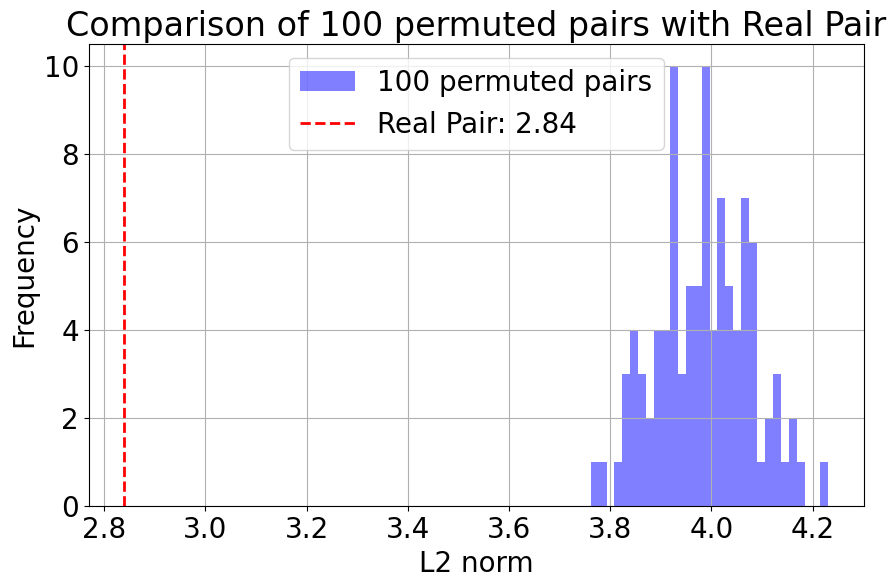

In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
# Creating the histogram
plt.figure(figsize=(10,6))
plt.hist(r_norm, bins=30, alpha=0.5, label="100 permuted pairs", color='b')

# Adding the line to mark the value
plt.axvline(real_norm, color='r', linestyle='dashed', linewidth=2, label=f"Real Pair: {real_norm:.2f}")

plt.title('Comparison of 100 permuted pairs with Real Pair')
plt.xlabel('L2 norm')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig('sbert_L2.png')
plt.show()



# Cosine similarity

In [16]:
user_embedding = group_embeddings
user_boolean_embedding = group_boolean_embedding
np.random.seed(2)

In [17]:
import numpy as np
from sklearn.utils import shuffle

def leave_one_out_cosine(user_embedding, user_boolean_embedding, num_experiments=100, num_permutations=100):
    """
    Perform leave-one-out experiments to compute cosine similarities between predicted and actual embeddings.
    
    Parameters:
    - user_embedding: np.ndarray
        The embedding matrix of users.
    - user_boolean_embedding: np.ndarray
        The boolean indicator matrix for user attributes.
    - num_experiments: int, optional (default=100)
        Number of experiments to run in each permutation.
    - num_permutations: int, optional (default=100)
        Number of permutations (shuffles) to perform.
        
    Returns:
    - mean_real_similarity: float
        The mean cosine similarity from the real (unshuffled) data.
    - cosine_similarities: list of floats
        The mean cosine similarities from each permutation.
    """
    num_users = user_embedding.shape[0]
    real_similarities = []
    
    # Real data experiments (without shuffling)
    for _ in range(num_experiments):
        # Select a random user to remove
        removed_user_index = np.random.randint(num_users)
        
        # Remove the selected user from both matrices
        user_embedding1 = np.delete(user_embedding, removed_user_index, axis=0)
        user_boolean_embedding1 = np.delete(user_boolean_embedding, removed_user_index, axis=0)
        
        # Compute the attribute_embedding using the remaining users
        attribute_embedding = np.linalg.pinv(user_boolean_embedding1).dot(user_embedding1)
        
        # Compute the predicted embedding for the removed user
        removed_user = np.dot(user_boolean_embedding[removed_user_index], attribute_embedding)
        
        # Compute the similarity between the predicted embedding and the real embedding
        real_user_embedding = user_embedding[removed_user_index]
        similarity = np.dot(removed_user, real_user_embedding) / (np.linalg.norm(removed_user) * np.linalg.norm(real_user_embedding))
        similarity = np.clip(similarity, -1, 1)
        real_similarities.append(similarity)
    
    mean_real_similarity = np.mean(real_similarities)
    print("Mean similarity with real embeddings:", mean_real_similarity)
    
    # Permuted data experiments
    cosine_similarities = []
    sum1 = 0
    for _ in range(num_permutations):
        mean_for_1 = []
        for _ in range(num_experiments):
            # Shuffle the user embeddings
            shuffled_embedding = shuffle(user_embedding, random_state=None)
            
            # Select a random user index to remove
            removed_user_index = np.random.randint(num_users)
            
            # Remove the selected user from both matrices
            user_embedding1 = np.delete(shuffled_embedding, removed_user_index, axis=0)
            user_boolean_embedding1 = np.delete(user_boolean_embedding, removed_user_index, axis=0)
            
            # Compute the attribute_embedding using the remaining users
            attribute_embedding = np.linalg.pinv(user_boolean_embedding1).dot(user_embedding1)
            
            # Compute the predicted embedding for the removed user
            removed_user = np.dot(user_boolean_embedding[removed_user_index], attribute_embedding)
            real_user_embedding = shuffled_embedding[removed_user_index]
            
            # Compute the similarity
            permuted_cosine_similarity = np.dot(removed_user, real_user_embedding) / (np.linalg.norm(removed_user) * np.linalg.norm(real_user_embedding))
            permuted_cosine_similarity = np.clip(permuted_cosine_similarity, -1, 1)
            mean_for_1.append(permuted_cosine_similarity)
        
        # Count how many permuted similarities exceed the real mean similarity
        count = sum(1 for x in mean_for_1 if x > mean_real_similarity)
        sum1 += count
        
        # Append the mean similarity of this permutation
        cosine_similarities.append(np.mean(mean_for_1))
    
    # Print the mean similarity from permuted embeddings
    print("Mean similarity with permuted embeddings:", np.mean(cosine_similarities))
    
    return mean_real_similarity, cosine_similarities


In [18]:
# Assuming you have your user_embedding and user_boolean_embedding defined
mean_real_similarity, cosine_similarities = leave_one_out_cosine(
    user_embedding=group_embeddings,
    user_boolean_embedding=group_boolean_embedding,
    num_experiments=100,
    num_permutations=100
)


Mean similarity with real embeddings: 0.7761361450996082
Mean similarity with permuted embeddings: 0.4865256543145181


In [19]:
min(cosine_similarities), max(cosine_similarities)

(0.4411758315491688, 0.5468915499478165)

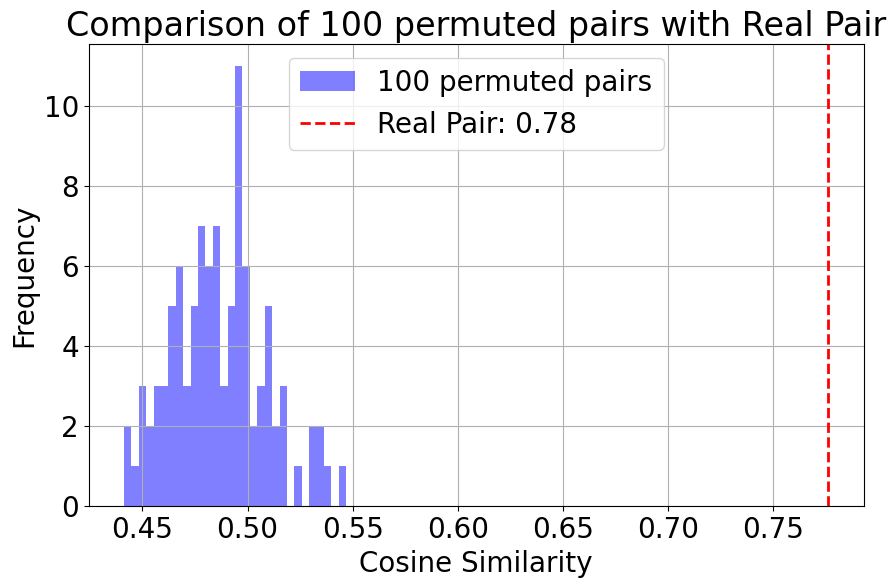

In [20]:
import matplotlib.pyplot as plt
# Creating the histogram
plt.figure(figsize=(10,6))
plt.hist(cosine_similarities, bins=30, alpha=0.5, label="100 permuted pairs", color='b')

# Adding the line to mark the value
plt.axvline(mean_real_similarity, color='r', linestyle='dashed', linewidth=2, label=f"Real Pair: {mean_real_similarity:.2f}")

plt.title('Comparison of 100 permuted pairs with Real Pair')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig('sbert_cos.png')
plt.show()


# Retrieval Accuracy

In [23]:
user_embedding = group_embeddings
user_boolean_embedding = group_boolean_embedding
np.random.seed(2)

In [24]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def leave_one_out_retrieval(user_embedding, user_boolean_embedding, num_trials=100, num_permutations=100):
    np.random.seed(2)
    """
    Perform leave-one-out retrieval experiments to compute hits@5 accuracy of predicting a user's embedding.

    Parameters:
    - user_embedding: np.ndarray
        The embedding matrix of users.
    - user_boolean_embedding: np.ndarray
        The boolean indicator matrix for user attributes.
    - num_trials: int, optional (default=100)
        Number of trials to run in each experiment.
    - num_permutations: int, optional (default=100)
        Number of permutations (shuffles) to perform in permuted experiments.

    Returns:
    - hits_at_5_real: float
        The hits@5 accuracy of retrieval on real embeddings.
    - hits_at_5_permuted: list of floats
        The hits@5 accuracies of retrieval on permuted embeddings for each permutation.
    """
    num_users = user_embedding.shape[0]

    # --- Real Data Experiment ---
    count_real_hits_5 = 0
    for _ in range(num_trials):
        # Select a random user index to remove
        removed_user_index = np.random.randint(num_users)

        # Remove the selected user from both matrices
        user_embedding1 = np.delete(user_embedding, removed_user_index, axis=0)
        user_boolean_embedding1 = np.delete(user_boolean_embedding, removed_user_index, axis=0)

        # Compute the attribute_embedding using the remaining users
        attribute_embedding = np.linalg.pinv(user_boolean_embedding1).dot(user_embedding1)

        # Compute the predicted embedding for the removed user
        removed_user = np.dot(user_boolean_embedding[removed_user_index], attribute_embedding)

        # Compute the cosine similarity between the predicted embedding and all user embeddings
        similarities = cosine_similarity(user_embedding, [removed_user]).flatten()

        # Get the indices of the top 5 most similar embeddings
        top_5_indices = np.argsort(-similarities)[:5]

        # Check if the removed user index is within the top 5
        if removed_user_index in top_5_indices:
            count_real_hits_5 += 1

    # Compute the hits@5 accuracy for real embeddings
    hits_at_5_real = count_real_hits_5 / num_trials
    print("Hits@5 accuracy with real embeddings:", hits_at_5_real)

    # --- Permuted Data Experiments ---
    hits_at_5_permuted = []
    for _ in range(num_permutations):
        count_permutation_hits_5 = 0
        # Shuffle the user embeddings
        shuffled_embedding = user_embedding.copy()
        np.random.shuffle(shuffled_embedding)

        for _ in range(num_trials):
            # Select a random user index to remove
            removed_user_index = np.random.randint(num_users)

            # Remove the selected user from both matrices
            user_embedding1 = np.delete(shuffled_embedding, removed_user_index, axis=0)
            user_boolean_embedding1 = np.delete(user_boolean_embedding, removed_user_index, axis=0)

            # Compute the attribute_embedding using the remaining users
            attribute_embedding = np.linalg.pinv(user_boolean_embedding1).dot(user_embedding1)

            # Compute the predicted embedding for the removed user
            removed_user = np.dot(user_boolean_embedding[removed_user_index], attribute_embedding)

            # Compute the cosine similarity between the predicted embedding and all user embeddings
            similarities = cosine_similarity(shuffled_embedding, [removed_user]).flatten()

            # Get the indices of the top 5 most similar embeddings
            top_5_indices = np.argsort(-similarities)[:5]

            # Check if the removed user index is within the top 5
            if removed_user_index in top_5_indices:
                count_permutation_hits_5 += 1

        # Compute hits@5 accuracy for this permutation
        hits_at_5_permutation = count_permutation_hits_5 / num_trials
        hits_at_5_permuted.append(hits_at_5_permutation)

    # Compute mean hits@5 accuracy for permuted embeddings
    mean_hits_at_5_permuted = np.mean(hits_at_5_permuted)
    print("Mean hits@5 accuracy with permuted embeddings:", mean_hits_at_5_permuted)

    return hits_at_5_real, hits_at_5_permuted


In [25]:
# Assuming you have your user_embedding and user_boolean_embedding defined
accuracy_real, accuracies_permuted = leave_one_out_retrieval(
    user_embedding=user_embedding,
    user_boolean_embedding=user_boolean_embedding,
    num_trials=100,
    num_permutations=100
)


Hits@5 accuracy with real embeddings: 0.59
Mean hits@5 accuracy with permuted embeddings: 0.04049999999999999


In [27]:
min(accuracies_permuted), max(accuracies_permuted)

(0.0, 0.11)

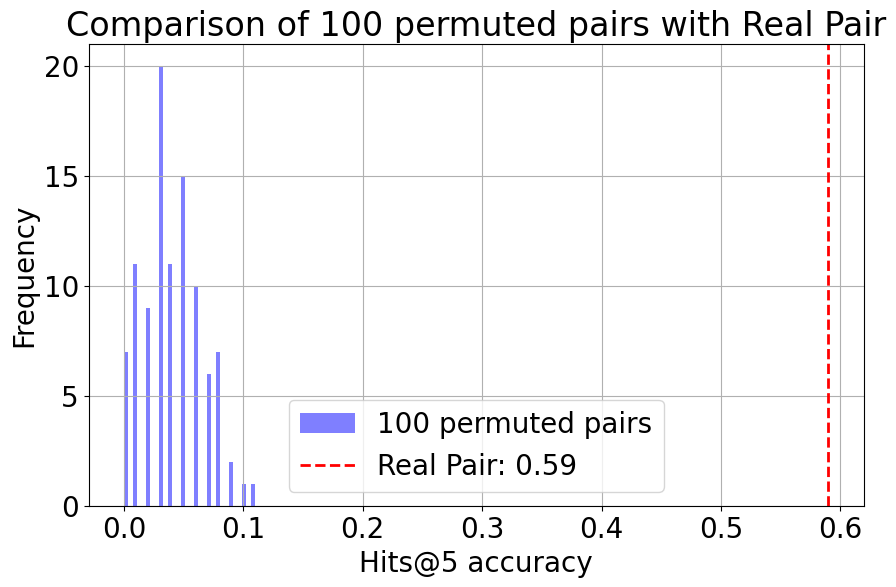

In [28]:
import matplotlib.pyplot as plt
# Creating the histogram
plt.figure(figsize=(10,6))
plt.hist(accuracies_permuted, bins=30, alpha=0.5, label="100 permuted pairs", color='b')

# Adding the line to mark the value
plt.axvline(accuracy_real, color='r', linestyle='dashed', linewidth=2, label=f"Real Pair: {accuracy_real:.2f}")

plt.title('Comparison of 100 permuted pairs with Real Pair')
plt.xlabel('Hits@5 accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig('sbert_hits5.png')
plt.show()